# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

## Load Dataset

In [2]:
# Read 'Customer ID' and 'Invoice ID'as String
df = pd.read_csv('data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
# Transfer 'InvoiceDate' to date format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


## Data Cleansing

In [3]:
# Remove oberservations w/o 'CustomerID'
# We are impossible to impute values for those customers
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

# Remove 'Return' or 'Negative Price' (Cancelled items)
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]

df.info()
df.describe()
print(df.head(5))

# Export to Cleansed Dateframe
# df.to_csv('data_cleansed.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029

In [4]:
flag = df['InvoiceDate'] < datetime.datetime(2011,11,8)
df_train = df[flag]
df_test = df[-flag]

In [5]:
df_train['Amount'] = df_train['UnitPrice'] * df_train['Quantity']
df_train.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [6]:
df_test['Amount'] = df_test['UnitPrice'] * df_test['Quantity']
df_test.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
447057,574943,17012D,ORIGAMI ROSE INCENSE/CANDLE SET,24,2011-11-08 07:52:00,0.85,13026,United Kingdom,20.4
447058,574943,17012F,ORIGAMI SANDLEWOOD INCENSE/CAND SET,24,2011-11-08 07:52:00,0.85,13026,United Kingdom,20.4
447059,574943,21636,MADRAS NOTEBOOK MEDIUM,12,2011-11-08 07:52:00,0.75,13026,United Kingdom,9.0
447060,574943,21991,BOHEMIAN COLLAGE STATIONERY SET,12,2011-11-08 07:52:00,1.25,13026,United Kingdom,15.0
447061,574943,35651,VINTAGE BEAD PINK SCARF,24,2011-11-08 07:52:00,1.65,13026,United Kingdom,39.6


## Data Exploration

### Countries Distribution

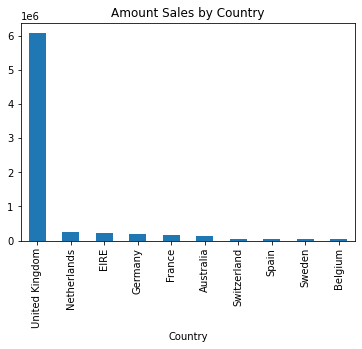

In [7]:
g = df_train.groupby(by=["Country"]).Amount.sum().sort_values(ascending = False).head(10).\
plot(kind='bar', title='Amount Sales by Country')

### Customer and Products

In [8]:
# Count of total transactions, products, and customers
summary = pd.DataFrame([{'Products': len(df_train['StockCode'].value_counts()),    
               'Transactions': len(df_train['InvoiceNo'].value_counts()),
               'Customers': len(df_train['CustomerID'].value_counts()),  
              }], columns = ['Transactions','Products', 'Customers'], index = ['Quantity'])
summary

,Transactions,Products,Customers
Quantity,15634,3623,4055


In [9]:
# Num of products purchased in every transaction
frame = df_train.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = frame.rename(columns = {'InvoiceDate':'Number of Products'})
print(nb_products_per_basket.head(10))
nb_products_per_basket.describe().T

  CustomerID InvoiceNo  Number of Products
0      12346    541431                   1
1      12347    537626                  31
2      12347    542237                  29
3      12347    549222                  24
4      12347    556201                  18
5      12347    562032                  22
6      12347    573511                  47
7      12348    539318                  17
8      12348    541998                   6
9      12348    548955                   5


,count,mean,std,min,25%,50%,75%,max
Number of Products,15634.0,21.051618,23.33757,1.0,6.0,15.0,27.0,435.0


### Basket Price

In [10]:
# Calculate basket price
frame = df_train.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Amount'].sum()
basket_price = frame.rename(columns = {'Amount':'Basket Price'})

# Add date of the order
df_train['InvoiceDate_int'] = df_train['InvoiceDate'].astype('int64')
frame = df_train.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_train.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(frame['InvoiceDate_int'])

print(basket_price.head(5))
basket_price.describe().T

  CustomerID InvoiceNo  Basket Price                   InvoiceDate
0      12346    541431      77183.60 2011-01-18 10:01:00.000000000
1      12347    537626        711.79 2010-12-07 14:57:00.000000000
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:43:00.000000000
4      12347    556201        382.52 2011-06-09 13:01:00.000000000


,count,mean,std,min,25%,50%,75%,max
Basket Price,15634.0,478.940589,1198.461236,0.38,157.72,303.77,477.5375,77183.6


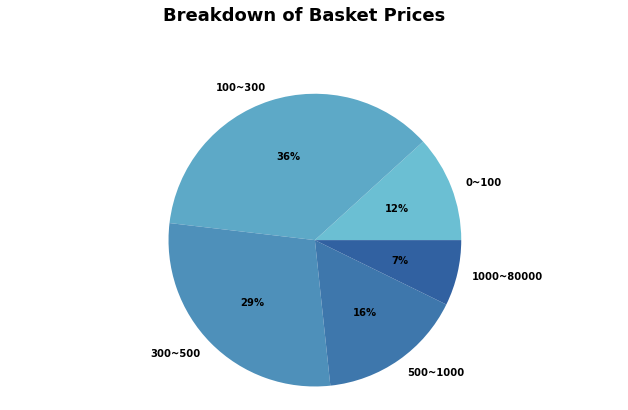

In [11]:
# Visualize basket prices based on percentile
price_range = [0, 100, 300, 500, 1000,80000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['#6BBFD3', '#5DA9C7', '#4E90BA', '#3E77AC', '#3161A1', '#224B95']
labels = [ '{}~{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of Basket Prices", ha='center', fontsize = 18);

### Stock Code

In [12]:
# Check the different type of stock codes
list_special_codes = df_train[df_train['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [13]:
# Check descriptions of different stock codes
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_train[df_train['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


# Feature Engineering

## RFM Model

Reference Date for Training Set: 2011-11-08 17:50:00


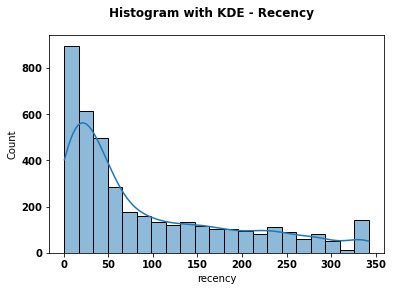

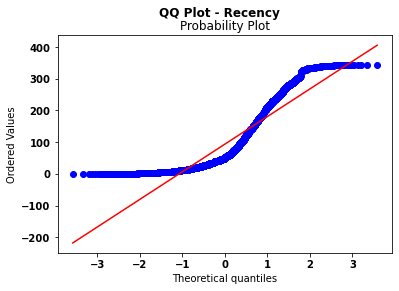

In [14]:
# Recency for Training Set
refrence_date_train = df_train.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date for Training Set:', refrence_date_train)
df_train['days_since_last_purchase'] = (refrence_date_train - df_train.InvoiceDate).astype('timedelta64[D]')
df_cus_rfm_train =  df_train[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
df_cus_rfm_train.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
# print(df_cus_rfm_train.head(5))

fig = plt.figure()
sns.histplot(data=df_cus_rfm_train.recency, kde=True)
fig.suptitle('Histogram with KDE - Recency', fontweight='bold')
plt.show()

fig = plt.figure()
res = stats.probplot(df_cus_rfm_train.recency, plot=plt)
fig.suptitle('QQ Plot - Recency', fontweight='bold')
plt.show()

In [15]:
# Recency for Testing Set
refrence_date_test = df_test.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date for Testing Set:', refrence_date_test)
df_test['days_since_last_purchase'] = (refrence_date_test - df_test['InvoiceDate'])/np.timedelta64(1, 'D')
df_cus_rfm_test =  df_test[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
df_cus_rfm_test.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
# print(df_cus_rfm_test.tail(5))

Reference Date for Testing Set: 2011-12-10 12:50:00


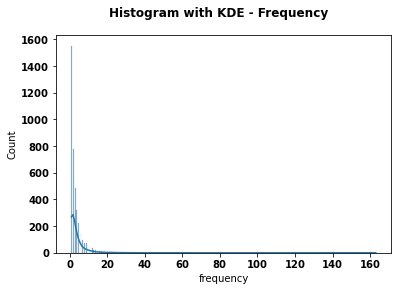

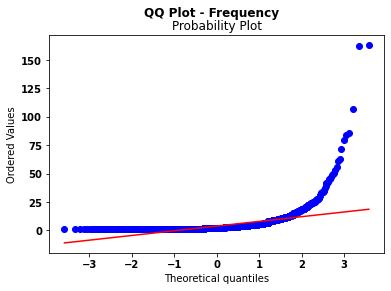

In [16]:
# Frequency for Training Set
customer_freq_train = (df_train[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq_train.rename(columns={'InvoiceNo':'frequency'},inplace=True)
df_cus_rfm_train = df_cus_rfm_train.merge(customer_freq_train)
# print(df_cus_rfm_train.head(5))

fig = plt.figure()
sns.histplot(data=df_cus_rfm_train.frequency, kde=True)
fig.suptitle('Histogram with KDE - Frequency', fontweight='bold')
plt.show()

fig = plt.figure()
res = stats.probplot(df_cus_rfm_train.frequency, plot=plt)
fig.suptitle('QQ Plot - Frequency', fontweight='bold')
plt.show()

In [17]:
# Frequency for Testing Set
customer_freq_test = (df_test[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq_test.rename(columns={'InvoiceNo':'frequency'},inplace=True)
df_cus_rfm_test = df_cus_rfm_test.merge(customer_freq_test)

           recency    frequency  monetaryValue
count  4055.000000  4055.000000    4055.000000
mean     93.915906     3.855487    1846.549241
std      94.930146     6.724902    8004.381037
min       1.000000     1.000000       2.900000
25%      20.000000     1.000000     294.260000
50%      50.000000     2.000000     635.660000
75%     152.000000     4.000000    1540.855000
max     342.000000   163.000000  247885.680000


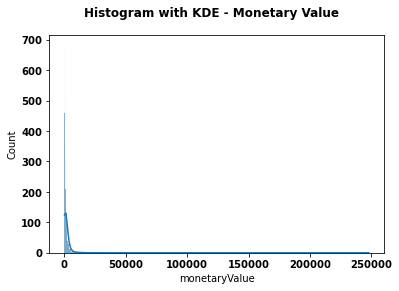

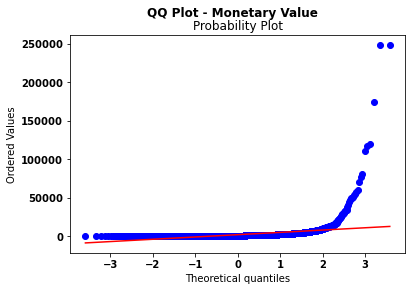

In [18]:
# Monetary Value for Training Set
customer_monetary_val_train = df_train[['CustomerID', 'Amount']].groupby("CustomerID").sum().reset_index()
customer_monetary_val_train.rename(columns={'Amount':'monetaryValue'},inplace=True)
df_cus_rfm_train = df_cus_rfm_train.merge(customer_monetary_val_train)
print(df_cus_rfm_train.describe())

fig = plt.figure()
sns.histplot(data=df_cus_rfm_train.monetaryValue, kde=True)
fig.suptitle('Histogram with KDE - Monetary Value', fontweight='bold')
plt.show()

fig = plt.figure()
res = stats.probplot(df_cus_rfm_train.monetaryValue, plot=plt)
fig.suptitle('QQ Plot - Monetary Value', fontweight='bold')
plt.show()

In [19]:
# Monetary Value for Testing Set
customer_monetary_val_test = df_test[['CustomerID', 'Amount']].groupby("CustomerID").sum().reset_index()
customer_monetary_val_test.rename(columns={'Amount':'monetaryValue'},inplace=True)
df_cus_rfm_test = df_cus_rfm_test.merge(customer_monetary_val_train)

In [20]:
# Log-transfrmation for Training
# R,F,M are highly skewed, so we log-transfrom the data to deal with outliers
df_cus_rfm_train['recency_log'] = df_cus_rfm_train['recency'].apply(math.log)
df_cus_rfm_train['frequency_log'] = df_cus_rfm_train['frequency'].apply(math.log)
df_cus_rfm_train['monetaryValue_log'] = df_cus_rfm_train['monetaryValue'].apply(math.log)

In [21]:
# Log-transfrmation for Testing
df_cus_rfm_test['recency_log'] = df_cus_rfm_test['recency'].apply(math.log)
df_cus_rfm_test['frequency_log'] = df_cus_rfm_test['frequency'].apply(math.log)
df_cus_rfm_test['monetaryValue_log'] = df_cus_rfm_test['monetaryValue'].apply(math.log)

In [26]:
# Export customer RFM features
df_cus_rfm_train.to_csv('data_RFM_train.csv')
df_cus_rfm_test.to_csv('data_RFM_test.csv')

In [23]:
# # Standarization (zero mean & unit sd)
# df_cus_rfm_train_norm = df_cus_rfm_train.copy()
# df_cus_rfm_test_norm = df_cus_rfm_test.copy()

# mean_recency_log = df_cus_rfm_train['recency_log'].mean()
# sd_recency_log = df_cus_rfm_train['recency_log'].std()

# mean_freq_log = df_cus_rfm_train['frequency_log'].mean()
# sd_freq_log = df_cus_rfm_train['frequency_log'].std()

# mean_mv_log = df_cus_rfm_train['monetaryValue_log'].mean()
# sd_mv_log = df_cus_rfm_train['monetaryValue_log'].std()

# # Standarize Training Set with column mean and std
# df_cus_rfm_train_norm['recency_log_norm'] = (df_cus_rfm_train['recency_log'] - mean_recency_log) / sd_recency_log
# df_cus_rfm_train_norm['frequency_log_norm'] = (df_cus_rfm_train_norm['frequency_log'] - mean_freq_log) / sd_freq_log
# df_cus_rfm_train_norm['monetaryValue_log_norm'] = (df_cus_rfm_train_norm['monetaryValue_log'] - mean_mv_log) / sd_mv_log
# df_cus_rfm_train_norm.describe()

In [24]:
# # Standarize Testing Set with Training Set's colunn mean and std
# df_cus_rfm_test_norm['recency_log_norm'] = (df_cus_rfm_test['recency_log'] - mean_recency_log) / sd_recency_log
# df_cus_rfm_test_norm['frequency_log_norm'] = (df_cus_rfm_test['frequency_log'] - mean_freq_log) / sd_freq_log
# df_cus_rfm_test_norm['monetaryValue_log_norm'] = (df_cus_rfm_test['monetaryValue_log'] - mean_mv_log) / sd_mv_log
# df_cus_rfm_test_norm.describe()

In [25]:
# Export normed customer RFM features
# df_cus_rfm_train_norm.to_csv('data_RFM_train_norm.csv')
# df_cus_rfm_test_norm.to_csv('data_RFM_test_norm.csv')